<a href="https://colab.research.google.com/github/ElviraThjellesen/Elvira/blob/main/vandmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# vi vil gerne simulerer regnvejr over RUC og hvordan det ligger sig på terrænet

```
# Dette formateres som kode
```


In [9]:
!pip install rasterio # rasterio is not installed on colab

##Fremgangsmåde:
Jeg starter med at importere de bibliotekter som skal anvendes til koden:

```python
```

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import requests
from io import BytesIO

## For at løse en TIF fil ind som DTM, gør jeg:


```python
```

In [11]:
# -------------------------------
# GRID INITIALIZATION
# -------------------------------

# URL of the DSM file (raw file link from GitHub)
dsm_url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/ruc_dsm.tif"

# Download the file
response = requests.get(dsm_url)
tif_data = BytesIO(response.content)

# Open the TIFF file with rasterio
with rasterio.open(tif_data) as src:
    dtm = src.read(1)  # Read the first (and likely only) band as a NumPy array
    profile = src.profile  # Store metadata (e.g., resolution, CRS)

# Store the original DTM for visualization
original_dtm = np.copy(dtm)

nx, ny = dtm.shape  # Dimensions of the grid
# Initialize a grid for water depth (initially zero everywhere)
water_depth = np.zeros((nx, ny))

## derefter definerer vi de forskellige parameter som skal bruges i koden:

```python
```

In [12]:
# -------------------------------
# INPUT PARAMETERS
# -------------------------------

# Rainfall per timestep (uniform rain over the grid)
rainfall = np.full((nx, ny), 0.1)  # 1 cm of rain per timestep

# Infiltration per timestep (constant for all cells)
infiltration = np.full((nx, ny), 0.002)  # 2 mm infiltration per timestep

# Number of timesteps for simulation
timesteps = 100

## denne del af koden skaber vidsualieringen af vanddybden under simulationen

```python
```

In [13]:
# -------------------------------
# NEIGHBOR IDENTIFICATION FUNCTION
# -------------------------------

def get_neighbors(i, j):
    """
    Returns the neighboring cell indices (north, south, west, east) if within bounds.
    """
    neighbors = []
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # N, S, W, E
        ni, nj = i + di, j + dj
        if 0 <= ni < nx and 0 <= nj < ny:
            neighbors.append((ni, nj))
    return neighbors

##I dette step bliver DTM'en visualiseret:

```python
```

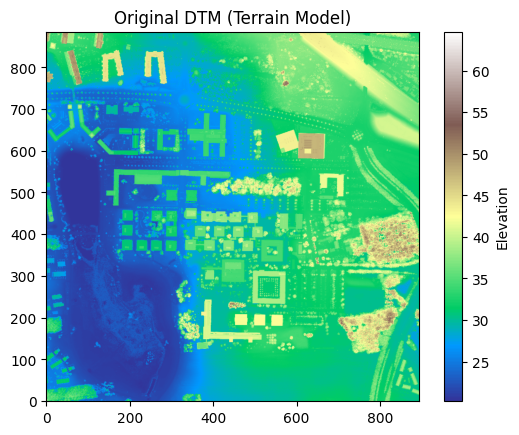

In [14]:
# -------------------------------
# VISUALIZE ORIGINAL DTM
# -------------------------------
plt.imshow(original_dtm, cmap="terrain", origin="lower")
plt.colorbar(label="Elevation")
plt.title("Original DTM (Terrain Model)")
plt.show()

##Den viser hvor vandet ligger sig
denne del af koden simulerer vandophobningen og strømning over flere tridsskridt ved at:

- tilføje regn til hver celle.
- anvende infiltration, så noget af vandet forsvinder i ned i jorden.
- beregne vandflow mellem naboceller baseret på højdeforskel, hvor vand kun  flyder nedad.
- fordele vandet proportionalt til at lavere naboceller for at sikre massen bevares.
- opdatere vanddybden for næste tidsskridt.

dette skaber en dynamisk model af, hvordan vand samler sig og bevæger sig hen over terrænet


```python
  ```

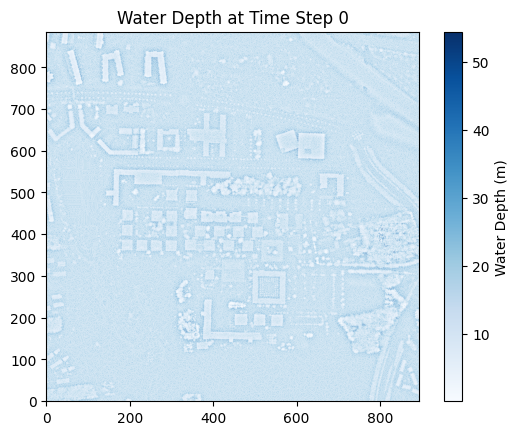

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-faaa1bcb8b1c>", line None, in <cell line: 0>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
# -------------------------------
# SIMULATION LOOP
# -------------------------------

# Iterate over multiple timesteps to model water accumulation and flow
for t in range(timesteps):
    # Create a new water depth grid for the next timestep
    new_water_depth = np.copy(water_depth)

    # Step 1: Add Rainfall to each cell
    new_water_depth += rainfall

    # Step 2: Apply Infiltration (cannot infiltrate more water than available in the cell)
    new_water_depth -= np.minimum(new_water_depth, infiltration)

    # Step 3: Compute Flow Between Neighboring Cells
    for i in range(nx):
        for j in range(ny):
            # Calculate the total height (terrain + water depth)
            cell_elevation = dtm[i, j] + water_depth[i, j]
            neighbors = get_neighbors(i, j)

            # Identify possible outflow to lower neighbors
            total_flow = 0
            flow_out = []
            for ni, nj in neighbors:
                neighbor_elevation = dtm[ni, nj] + water_depth[ni, nj]
                if cell_elevation > neighbor_elevation:  # Only flow downhill
                    flow_amount = (cell_elevation - neighbor_elevation) * 0.1  # Simplified flow formula
                    total_flow += flow_amount
                    flow_out.append((ni, nj, flow_amount))

            # Distribute Flow Proportionally
            if total_flow > 0:
                for ni, nj, flow_amount in flow_out:
                    transfer_amount = (flow_amount / total_flow) * water_depth[i, j]  # Ensure conservation of mass
                    new_water_depth[i, j] -= transfer_amount
                    new_water_depth[ni, nj] += transfer_amount

    # Update water depth for the next timestep
    water_depth = new_water_depth
    if t % 10 == 0:  # Update visualization every 10 timesteps
        visualize_water_depth(water_depth, t)

##denne del af koden skaber vidsualieringen af vanddybden under simulationen

```python
```

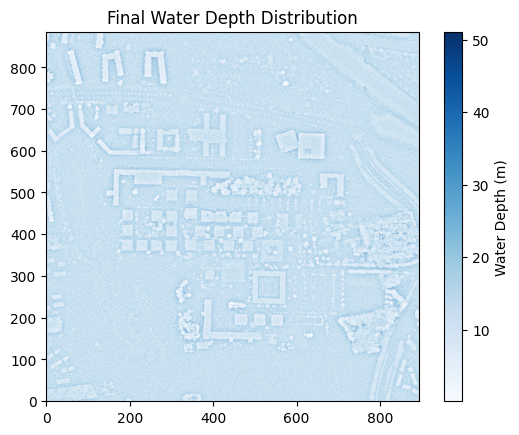

In [20]:
 # -------------------------------
    # VISUALIZATION
    # -------------------------------

    # Funktion til at visualisere med 95%-fraktil
def visualize_water_depth(water_depth, timestep = None):
    # Beregn 95%-fraktilen for vanddybden
    v_max = np.percentile(water_depth, 95)

    if t % 10 == 0:  # Update visualization every 10 timesteps
        plt.imshow(water_depth, cmap="Blues", origin="lower")
        plt.colorbar(label="Water Depth (m)")
        plt.title(f"Water Depth at Time Step {t}")
        plt.show()

# Final visualization
plt.imshow(water_depth, cmap="Blues", origin="lower")
plt.colorbar(label="Water Depth (m)")
plt.title("Final Water Depth Distribution")
plt.show()

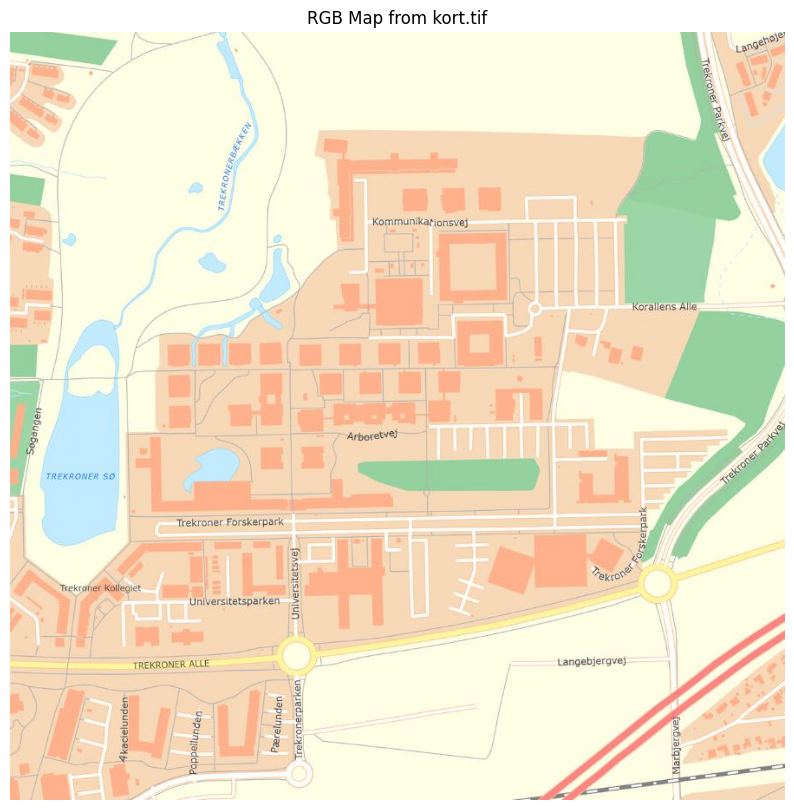

In [4]:
# URL of the raw TIFF file on GitHub
url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/kort.tif"

# Download the file
response = requests.get(url)
tif_data = BytesIO(response.content)

# Open the TIFF file with rasterio
with rasterio.open(tif_data) as src:
    # Read all bands (assuming RGB)
    img = src.read()  # Shape: (Bands, Height, Width)

    # Convert to (Height, Width, Bands) for display
    img = np.moveaxis(img, 0, -1)

    # Normalize the pixel values (if needed)
    if img.dtype == np.uint16:  # If 16-bit image
        img = img / 65535.0
    elif img.dtype == np.uint8:  # If 8-bit image
        img = img / 255.0

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")  # Hide axis
    plt.title("RGB Map from kort.tif")
    plt.show()

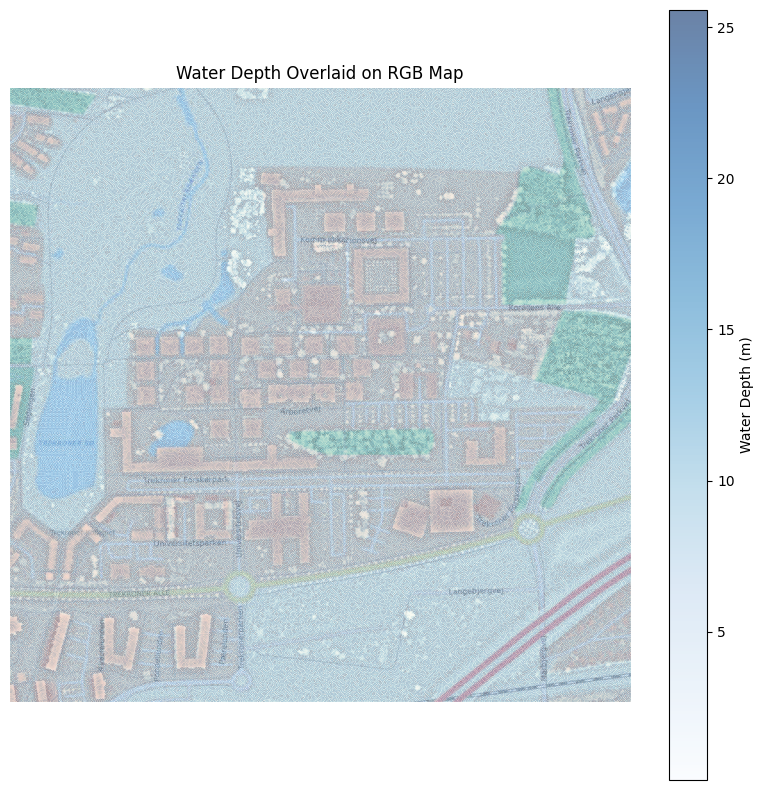

In [6]:
# -------------------------------
# HENT BAGGRUNDSKORT (kort.tif)
# -------------------------------
# URL of the raw TIFF file on GitHub
url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/kort.tif"

# Download the file
response = requests.get(url)
tif_data = BytesIO(response.content)

# Open the TIFF file with rasterio
with rasterio.open(tif_data) as src:
    # Read all bands (assuming RGB)
    img = src.read()  # Shape: (Bands, Height, Width)

    # Convert to (Height, Width, Bands) for display
    img = np.moveaxis(img, 0, -1)

    # Normalize the pixel values (if needed)
    if img.dtype == np.uint16:  # If 16-bit image
        img = img / 65535.0
    elif img.dtype == np.uint8:  # If 8-bit image
        img = img / 255.0

# -------------------------------
# HENT WATER DEPTH DATA
# -------------------------------
# Antag, at `water_depth` allerede er beregnet fra din simulation
# Eksempel på dummy data (hvis du vil teste uden simulation)
# water_depth = np.random.rand(img.shape[0], img.shape[1]) * 0.2

# Beregn 95%-fraktilen for at undgå outliers
v_max = np.percentile(water_depth, 95)

# -------------------------------
# PLOT BAGGRUNDSKORT + WATER DEPTH
# -------------------------------
plt.figure(figsize=(10, 10))

# 1️⃣ Plot RGB baggrundskort
plt.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])

# 2️⃣ Plot vanddybde med gennemsigtighed (alpha)
plt.imshow(water_depth, cmap="Blues", alpha=0.6, extent=[0, img.shape[1], 0, img.shape[0]], vmax=v_max)

# 3️⃣ Tilføj colorbar og styling
plt.colorbar(label="Water Depth (m)")
plt.axis("off")  # Fjern akser
plt.title("Water Depth Overlaid on RGB Map")
plt.show()

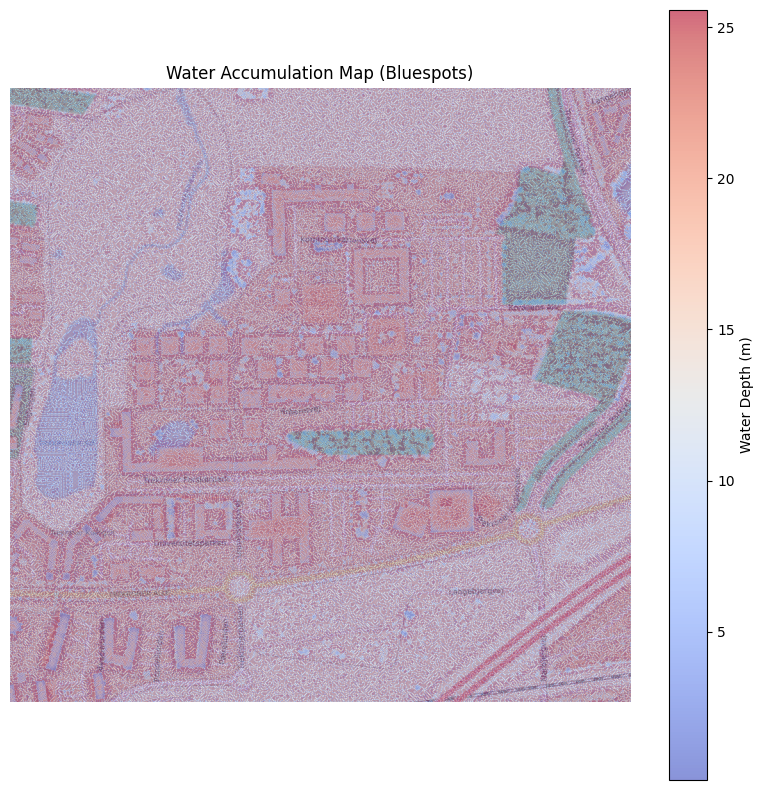

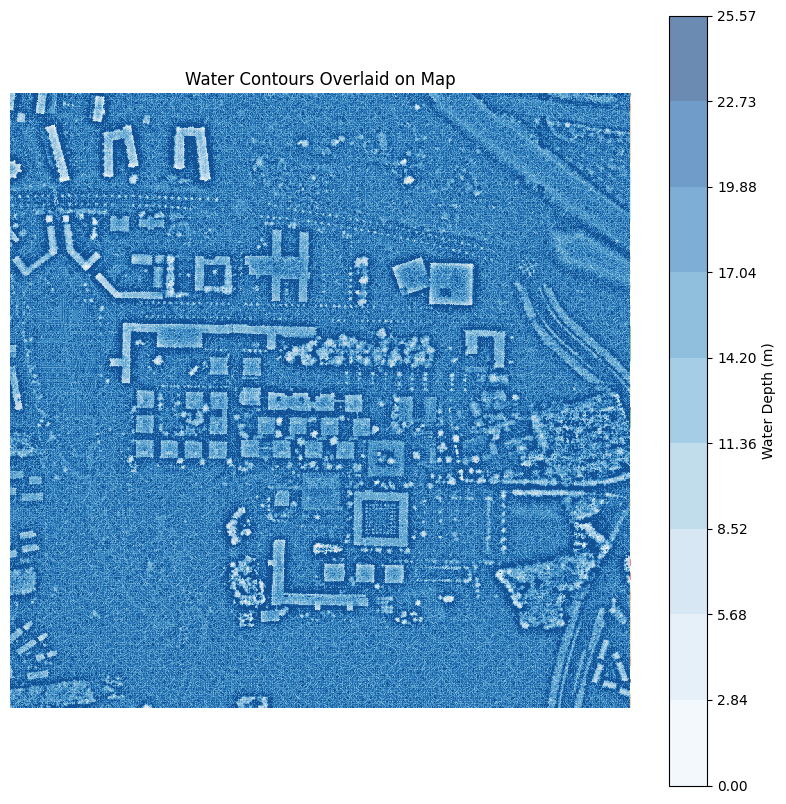

In [7]:
# -------------------------------
# HENT BAGGRUNDSKORT (kort.tif)
# -------------------------------
url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/kort.tif"
response = requests.get(url)
tif_data = BytesIO(response.content)

with rasterio.open(tif_data) as src:
    img = src.read()
    img = np.moveaxis(img, 0, -1)

    if img.dtype == np.uint16:
        img = img / 65535.0
    elif img.dtype == np.uint8:
        img = img / 255.0

# -------------------------------
# HENT WATER DEPTH DATA
# -------------------------------
# Antager at `water_depth` findes fra simulationen
# Dummy data til test: water_depth = np.random.rand(img.shape[0], img.shape[1]) * 0.2

# 95%-fraktilen for at undgå ekstreme outliers
v_max = np.percentile(water_depth, 95)

# -------------------------------
# VISUALISERING AF BLUESPOTS
# -------------------------------
plt.figure(figsize=(10, 10))

# 1️⃣ Baggrundskort
plt.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])

# 2️⃣ Bluespot heatmap (hvor vand ophober sig)
plt.imshow(water_depth, cmap="coolwarm", alpha=0.6, extent=[0, img.shape[1], 0, img.shape[0]], vmax=v_max)

# 3️⃣ Tilføj farvebar og styling
plt.colorbar(label="Water Depth (m)")
plt.axis("off")
plt.title("Water Accumulation Map (Bluespots)")
plt.show()

plt.figure(figsize=(10, 10))

# Baggrundskort
plt.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])

# Vandkonturer
levels = np.linspace(0, v_max, 10)  # 10 konturlinjer op til 95%-fraktilen
plt.contourf(water_depth, levels=levels, cmap="Blues", alpha=0.6, extent=[0, img.shape[1], 0, img.shape[0]])

plt.colorbar(label="Water Depth (m)")
plt.axis("off")
plt.title("Water Contours Overlaid on Map")
plt.show()

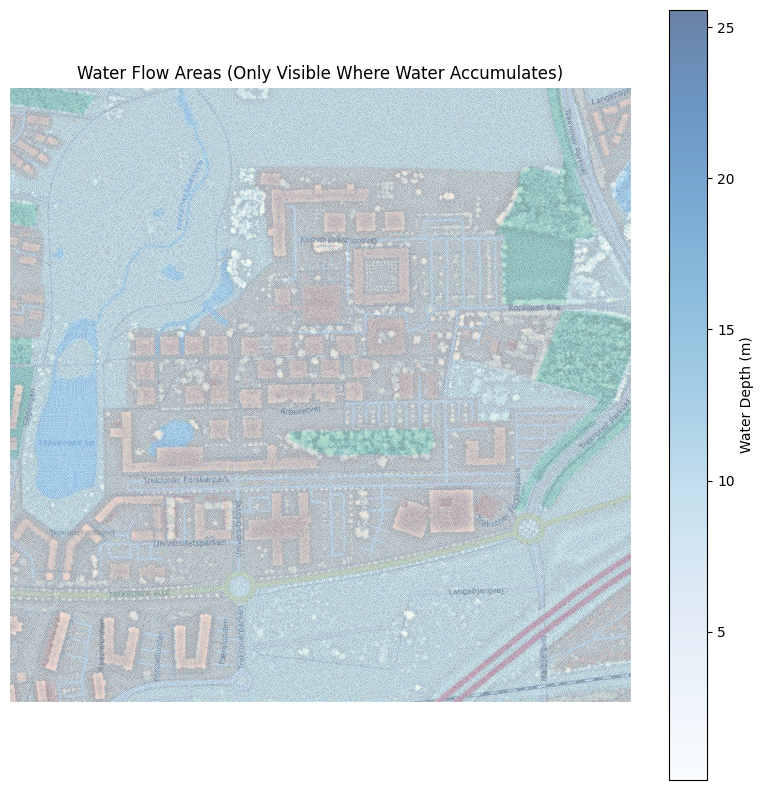

In [8]:
# -------------------------------
# HENT BAGGRUNDSKORT (kort.tif)
# -------------------------------
url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/kort.tif"
response = requests.get(url)
tif_data = BytesIO(response.content)

with rasterio.open(tif_data) as src:
    img = src.read()
    img = np.moveaxis(img, 0, -1)

    if img.dtype == np.uint16:
        img = img / 65535.0
    elif img.dtype == np.uint8:
        img = img / 255.0

# -------------------------------
# HENT WATER DEPTH DATA
# -------------------------------
# Antager at `water_depth` allerede findes
# Dummy-data til test: water_depth = np.random.rand(img.shape[0], img.shape[1]) * 0.2

# 95%-fraktil for at undgå outliers
v_max = np.percentile(water_depth, 95)

# **Definer en tærskel for synligt vand**
water_threshold = 0.01  # Kun vis celler med mere end 1 cm vand

# Lav en kopi af water_depth, hvor vi sætter alt under threshold til NaN (usynligt)
filtered_water_depth = np.where(water_depth > water_threshold, water_depth, np.nan)

# -------------------------------
# PLOT KORT MED KUN VANDANSAMLINGER
# -------------------------------
plt.figure(figsize=(10, 10))

# 1️⃣ Baggrundskort
plt.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])

# 2️⃣ Kun synlige vandceller over tærsklen
plt.imshow(filtered_water_depth, cmap="Blues", alpha=0.6, extent=[0, img.shape[1], 0, img.shape[0]], vmax=v_max)

# 3️⃣ Tilføj farvebar og styling
plt.colorbar(label="Water Depth (m)")
plt.axis("off")
plt.title("Water Flow Areas (Only Visible Where Water Accumulates)")
plt.show()